This notebook will load and store experiments' data fro each agent and all number of users

Then you can visualize the numerical and symbolic distribution of each agent's combination in the next code cells.

In [2]:
import sys
sys.path.insert(0, '../')

# # Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import ast
%matplotlib inline
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Import Constatns
from script.experiments_constants import AGENT_EXPERIMENT_INFO
from script.experiments_constants import ENV_KPI_NAME_LIST

from script.load_data import handle_data
from script.symbolic_representation import create_symbolic_state_decision_matrix

# Preprocess Data and SymbXRL process:
In this cell we will load the log file of all agents and store the mined data, and cleaned data slongside the symbxrl's fol-based symbolic represetnation.

In [11]:
agents = ['embb-trf1', 'embb-trf2', 'urllc-trf1', 'urllc-trf2']
users = [3, 4, 5, 6]

for agent in agents:
    for user in users:
        agent_info = AGENT_EXPERIMENT_INFO[agent]
        kpi_data, decision_data = handle_data(agent_info, user)
        symbolic_df, marker_df = create_symbolic_state_decision_matrix(kpi_data, decision_data, agent_info, user)
        symbolic_df['combined_decision'] = symbolic_df.apply(lambda row: f"{row['prb_decision']} - {row['sched_decision']}", axis=1)
        print(f"Agent: {agent} - Users: {user}")
        print("")
        

Agent: embb-trf1 - Users: 3

Agent: embb-trf1 - Users: 4

Agent: embb-trf1 - Users: 5

Agent: embb-trf1 - Users: 6

Agent: embb-trf2 - Users: 3

Agent: embb-trf2 - Users: 4

Agent: embb-trf2 - Users: 5

Agent: embb-trf2 - Users: 6

Agent: urllc-trf1 - Users: 3

Agent: urllc-trf1 - Users: 4

Agent: urllc-trf1 - Users: 5

Agent: urllc-trf1 - Users: 6

Agent: urllc-trf2 - Users: 3

Agent: urllc-trf2 - Users: 4

Agent: urllc-trf2 - Users: 5

Agent: urllc-trf2 - Users: 6



# Load and Show some results for each one of the agents

In this part we will load the data of one of the agents and visualize some of the numerical data.

In [30]:
# Choose one of the agents: 'embb-trf1', 'embb-trf2', 'urllc-trf1', 'urllc-trf2'
agent = 'embb-trf2'

# Choose one of the users: 3, 4, 5, 6 - Combination of agent and user will determine a specific experiment
user = 6

agent_info = AGENT_EXPERIMENT_INFO[agent]
kpi_data, decision_data = handle_data(agent_info, user)
symbolic_df, marker_df = create_symbolic_state_decision_matrix(kpi_data, decision_data, agent_info, user)
symbolic_df['combined_decision'] = symbolic_df.apply(lambda row: f"{row['prb_decision']} - {row['sched_decision']}", axis=1)
print(f"Agent: {agent} - Users: {user}")
print("")

Agent: embb-trf2 - Users: 6



## Plot the transmitt Bitrate

Numerical and the symbolic representation

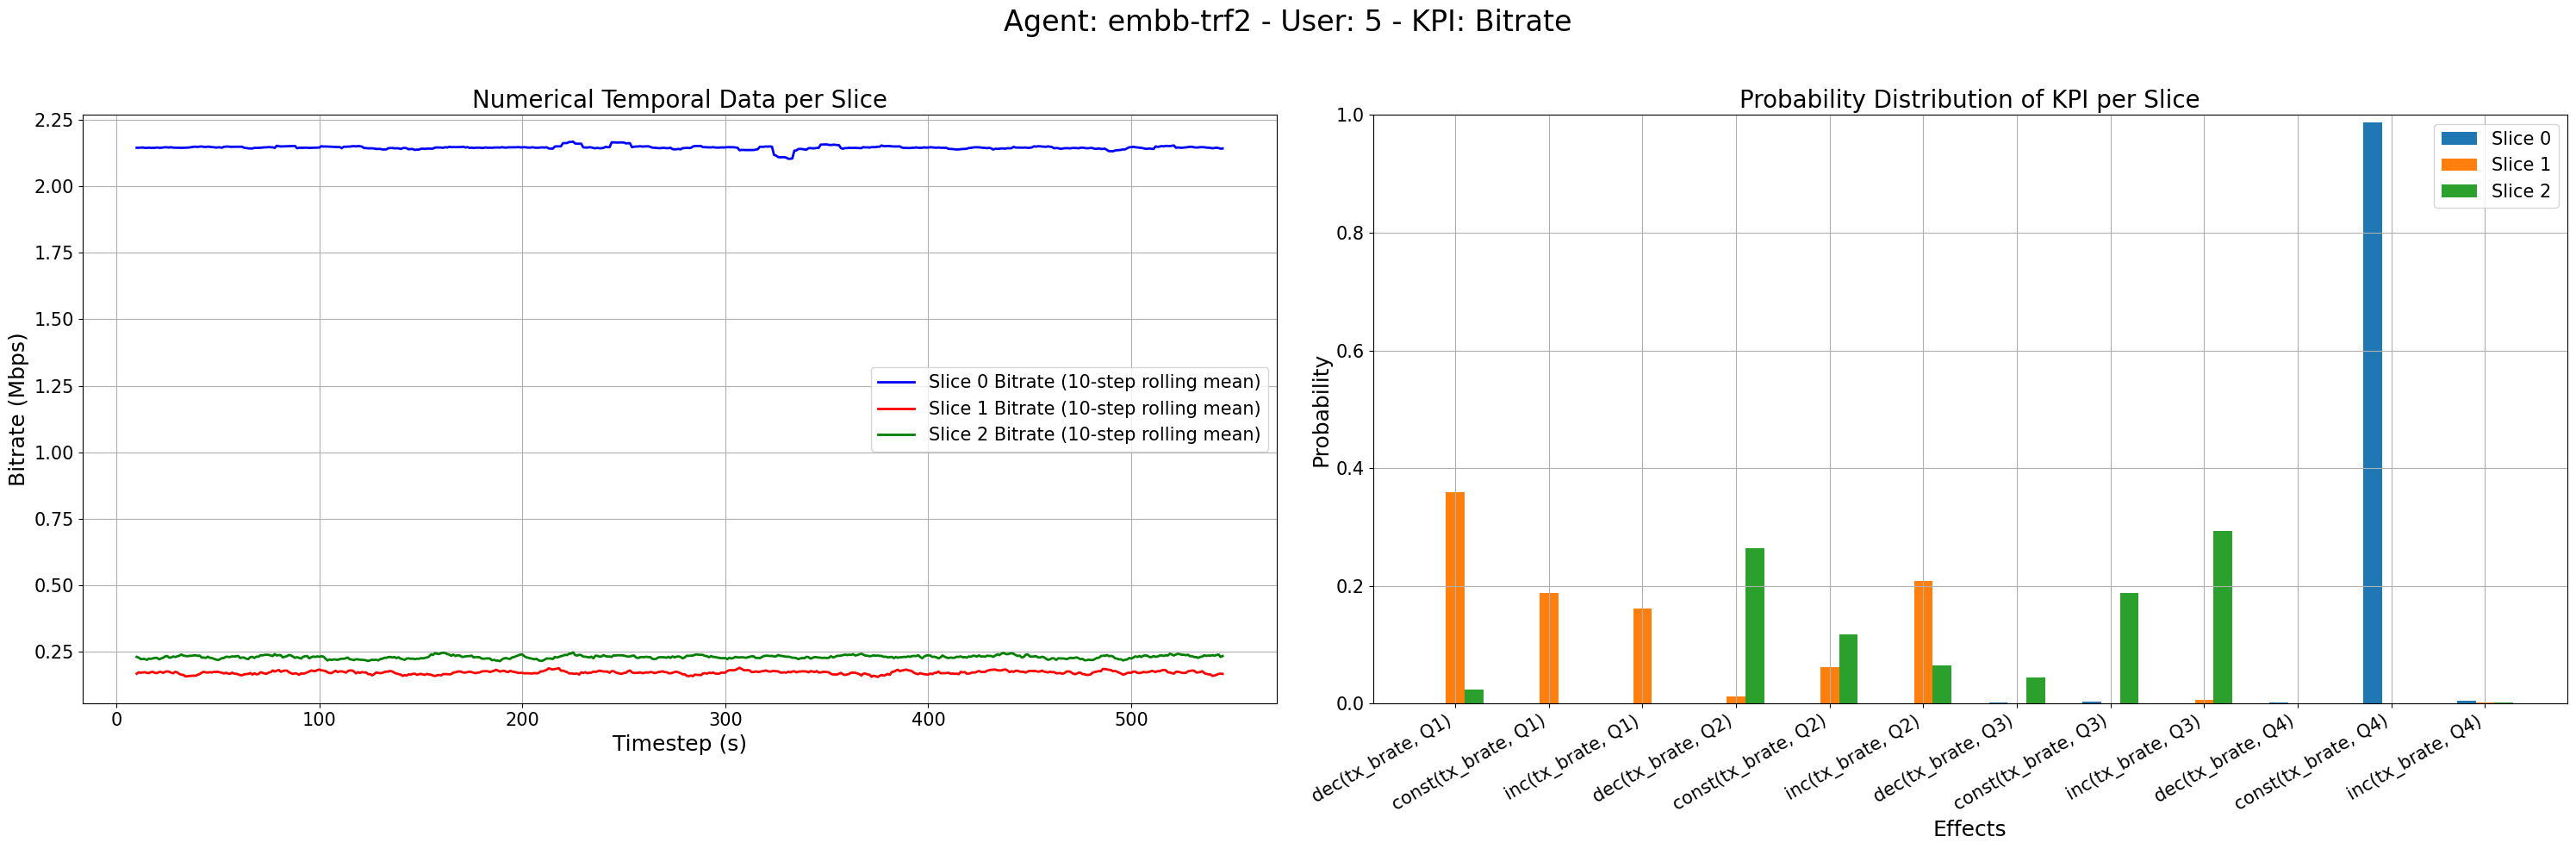

In [25]:
def create_effects_list(kpis=['tx_brate'], changes=['dec', 'const', 'inc']):
    return {
        kpi: [f'{change}({kpi}, Q{quartile})' for quartile in range(1, 5) for change in changes] for kpi in kpis
    }

effects_list = create_effects_list()

# Create a 1x2 subplot figure
fig, ax = plt.subplots(1, 2, figsize=(30, 10))

# Main title for the figure
fig.suptitle(f"Agent: {agent} - User: {user} - KPI: Bitrate", fontsize=24)

# First subplot: Numerical temporal data per slice
colors = ['blue', 'red', 'green']
for slice_id in [0, 1, 2]:
    # Extract the relevant data for each slice
    timestep = kpi_data[kpi_data['slice_id'] == slice_id]['timestep'][10:] - 10
    bitrate = kpi_data[kpi_data['slice_id'] == slice_id]['tx_brate'][10:].rolling(window=10).mean()
    
    # Plot the data
    ax[0].plot(timestep, bitrate, label=f'Slice {slice_id} Bitrate (10-step rolling mean)', color=colors[slice_id], linestyle='-', linewidth=2)

# Add grid, labels, title, and legend for the first subplot
ax[0].grid(True)
ax[0].set_xlabel("Timestep (s)", fontsize=18)
ax[0].set_ylabel("Bitrate (Mbps)", fontsize=18)
ax[0].set_title("Numerical Temporal Data per Slice", fontsize=20)
ax[0].legend(fontsize=15)
ax[0].tick_params(axis='both', labelsize=15)

# Second subplot: Probability distribution of symbolic effects per slice
bar_width = 0.2
x = np.arange(len(effects_list['tx_brate']))

for i, slice_id in enumerate([0, 1, 2]):
    effect_counts = symbolic_df[symbolic_df['slice_id'] == slice_id]['tx_brate'].value_counts(normalize=True).reindex(effects_list['tx_brate'], fill_value=0).reset_index()
    effect_counts.columns = ['effects', 'probability']
    
    # Plot the data as a bar plot
    ax[1].bar(x + i * bar_width, effect_counts['probability'], bar_width, label=f'Slice {slice_id}')

# Add grid, labels, and title for the second subplot
ax[1].grid(True)
ax[1].set_ylim(bottom=0, top=1)
ax[1].set_xticks(x + bar_width)
ax[1].set_xticklabels(effect_counts['effects'], rotation=30, ha='right', fontsize=12)
ax[1].set_xlabel("Effects", fontsize=18)
ax[1].set_ylabel("Probability", fontsize=18)
ax[1].set_title("Probability Distribution of KPI per Slice", fontsize=20)
ax[1].legend(fontsize=15)
ax[1].tick_params(axis='both', labelsize=15)

# Adjust layout for better fit
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show the plot
plt.show()

## Plot the transmitted packets

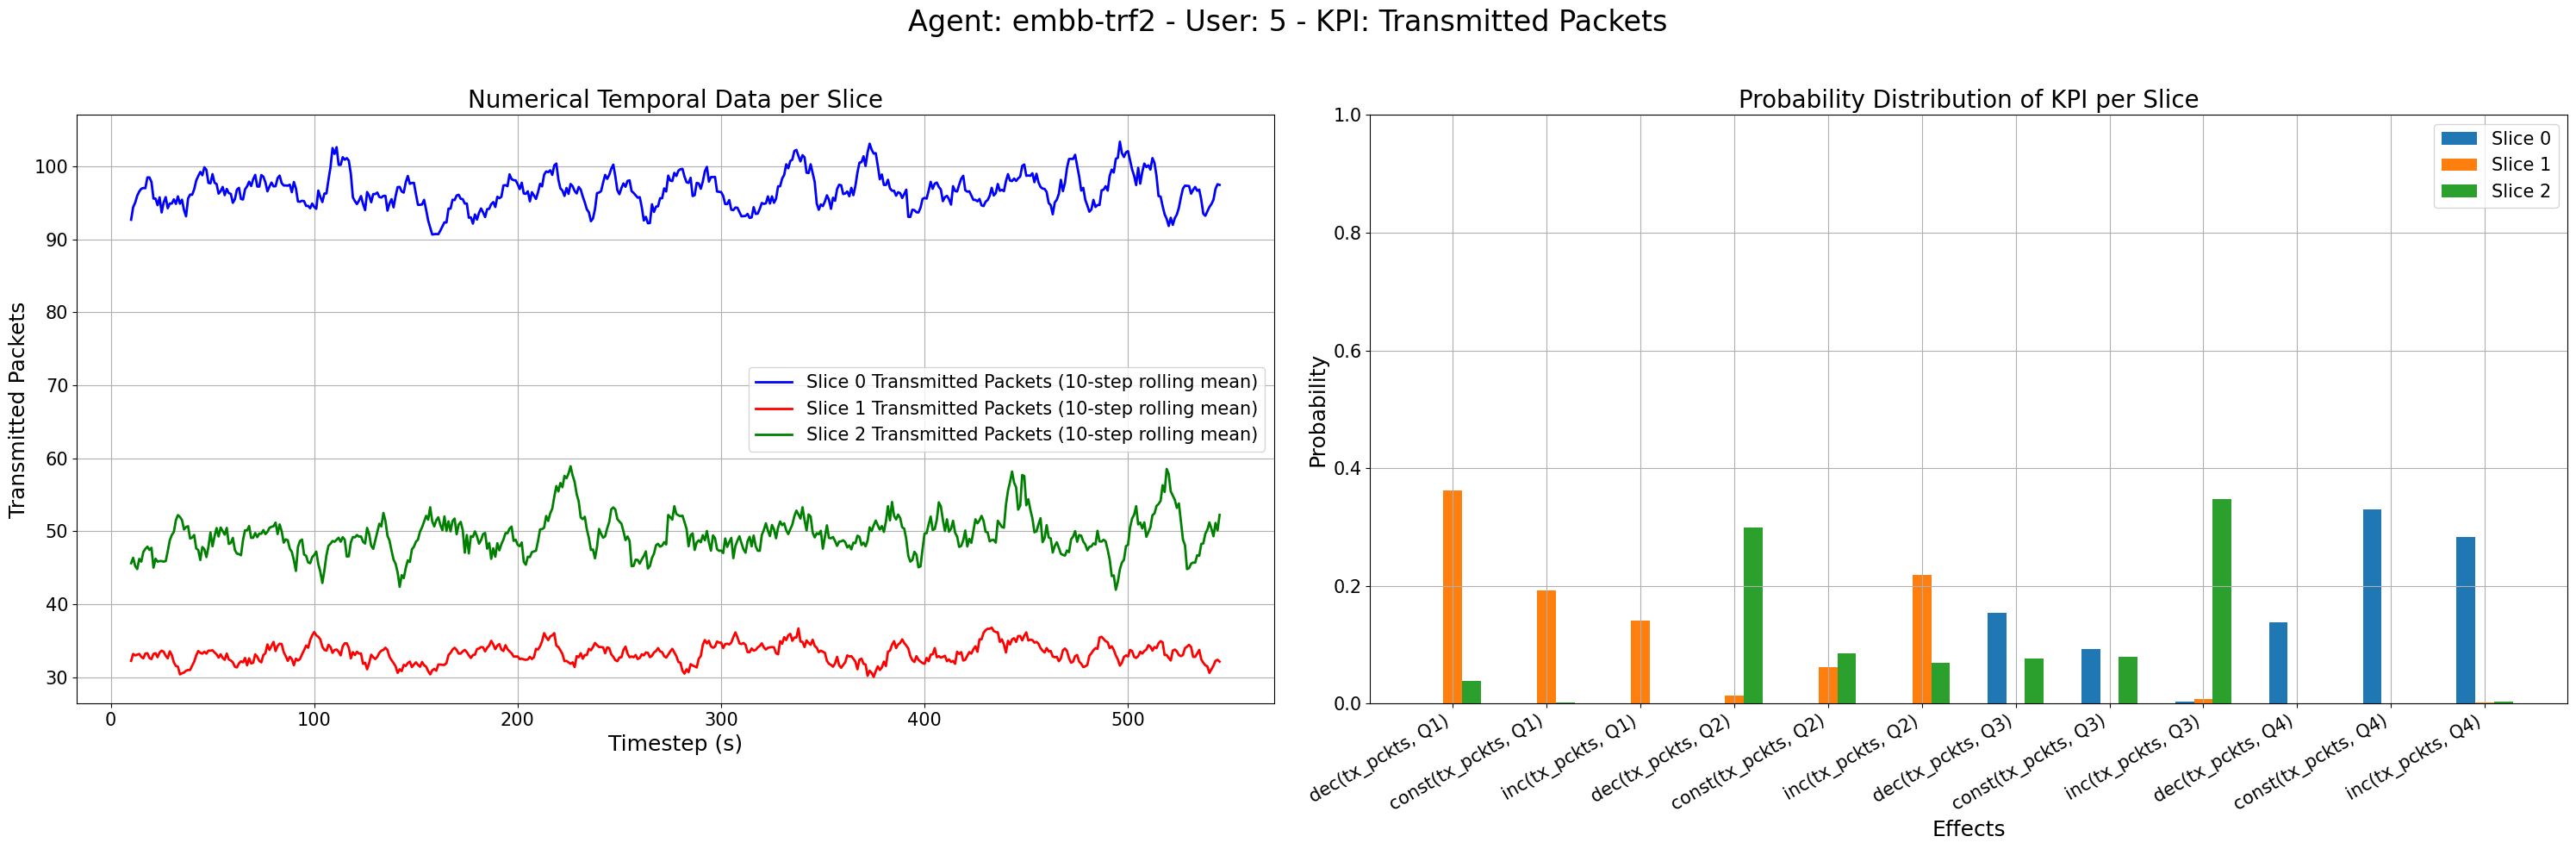

In [27]:
def create_effects_list(kpis=['tx_pckts'], changes=['dec', 'const', 'inc']):
    return {
        kpi: [f'{change}({kpi}, Q{quartile})' for quartile in range(1, 5) for change in changes] for kpi in kpis
    }

effects_list = create_effects_list()

# Create a 1x2 subplot figure
fig, ax = plt.subplots(1, 2, figsize=(30, 10))

# Main title for the figure
fig.suptitle(f"Agent: {agent} - User: {user} - KPI: Transmitted Packets", fontsize=24)

# First subplot: Numerical temporal data per slice
colors = ['blue', 'red', 'green']
for slice_id in [0, 1, 2]:
    # Extract the relevant data for each slice
    timestep = kpi_data[kpi_data['slice_id'] == slice_id]['timestep'][10:] - 10
    tx_pckts = kpi_data[kpi_data['slice_id'] == slice_id]['tx_pckts'][10:].rolling(window=10).mean()
    
    # Plot the data
    ax[0].plot(timestep, tx_pckts, label=f'Slice {slice_id} Transmitted Packets (10-step rolling mean)', color=colors[slice_id], linestyle='-', linewidth=2)

# Add grid, labels, title, and legend for the first subplot
ax[0].grid(True)
ax[0].set_xlabel("Timestep (s)", fontsize=18)
ax[0].set_ylabel("Transmitted Packets", fontsize=18)
ax[0].set_title("Numerical Temporal Data per Slice", fontsize=20)
ax[0].legend(fontsize=15)
ax[0].tick_params(axis='both', labelsize=15)

# Second subplot: Probability distribution of symbolic effects per slice
bar_width = 0.2
x = np.arange(len(effects_list['tx_pckts']))

for i, slice_id in enumerate([0, 1, 2]):
    effect_counts = symbolic_df[symbolic_df['slice_id'] == slice_id]['tx_pckts'].value_counts(normalize=True).reindex(effects_list['tx_pckts'], fill_value=0).reset_index()
    effect_counts.columns = ['effects', 'probability']
    
    # Plot the data as a bar plot
    ax[1].bar(x + i * bar_width, effect_counts['probability'], bar_width, label=f'Slice {slice_id}')

# Add grid, labels, and title for the second subplot
ax[1].grid(True)
ax[1].set_ylim(bottom=0, top=1)
ax[1].set_xticks(x + bar_width)
ax[1].set_xticklabels(effect_counts['effects'], rotation=30, ha='right', fontsize=12)
ax[1].set_xlabel("Effects", fontsize=18)
ax[1].set_ylabel("Probability", fontsize=18)
ax[1].set_title("Probability Distribution of KPI per Slice", fontsize=20)
ax[1].legend(fontsize=15)
ax[1].tick_params(axis='both', labelsize=15)

# Adjust layout for better fit
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show the plot
plt.show()

## Plot the Buffer size

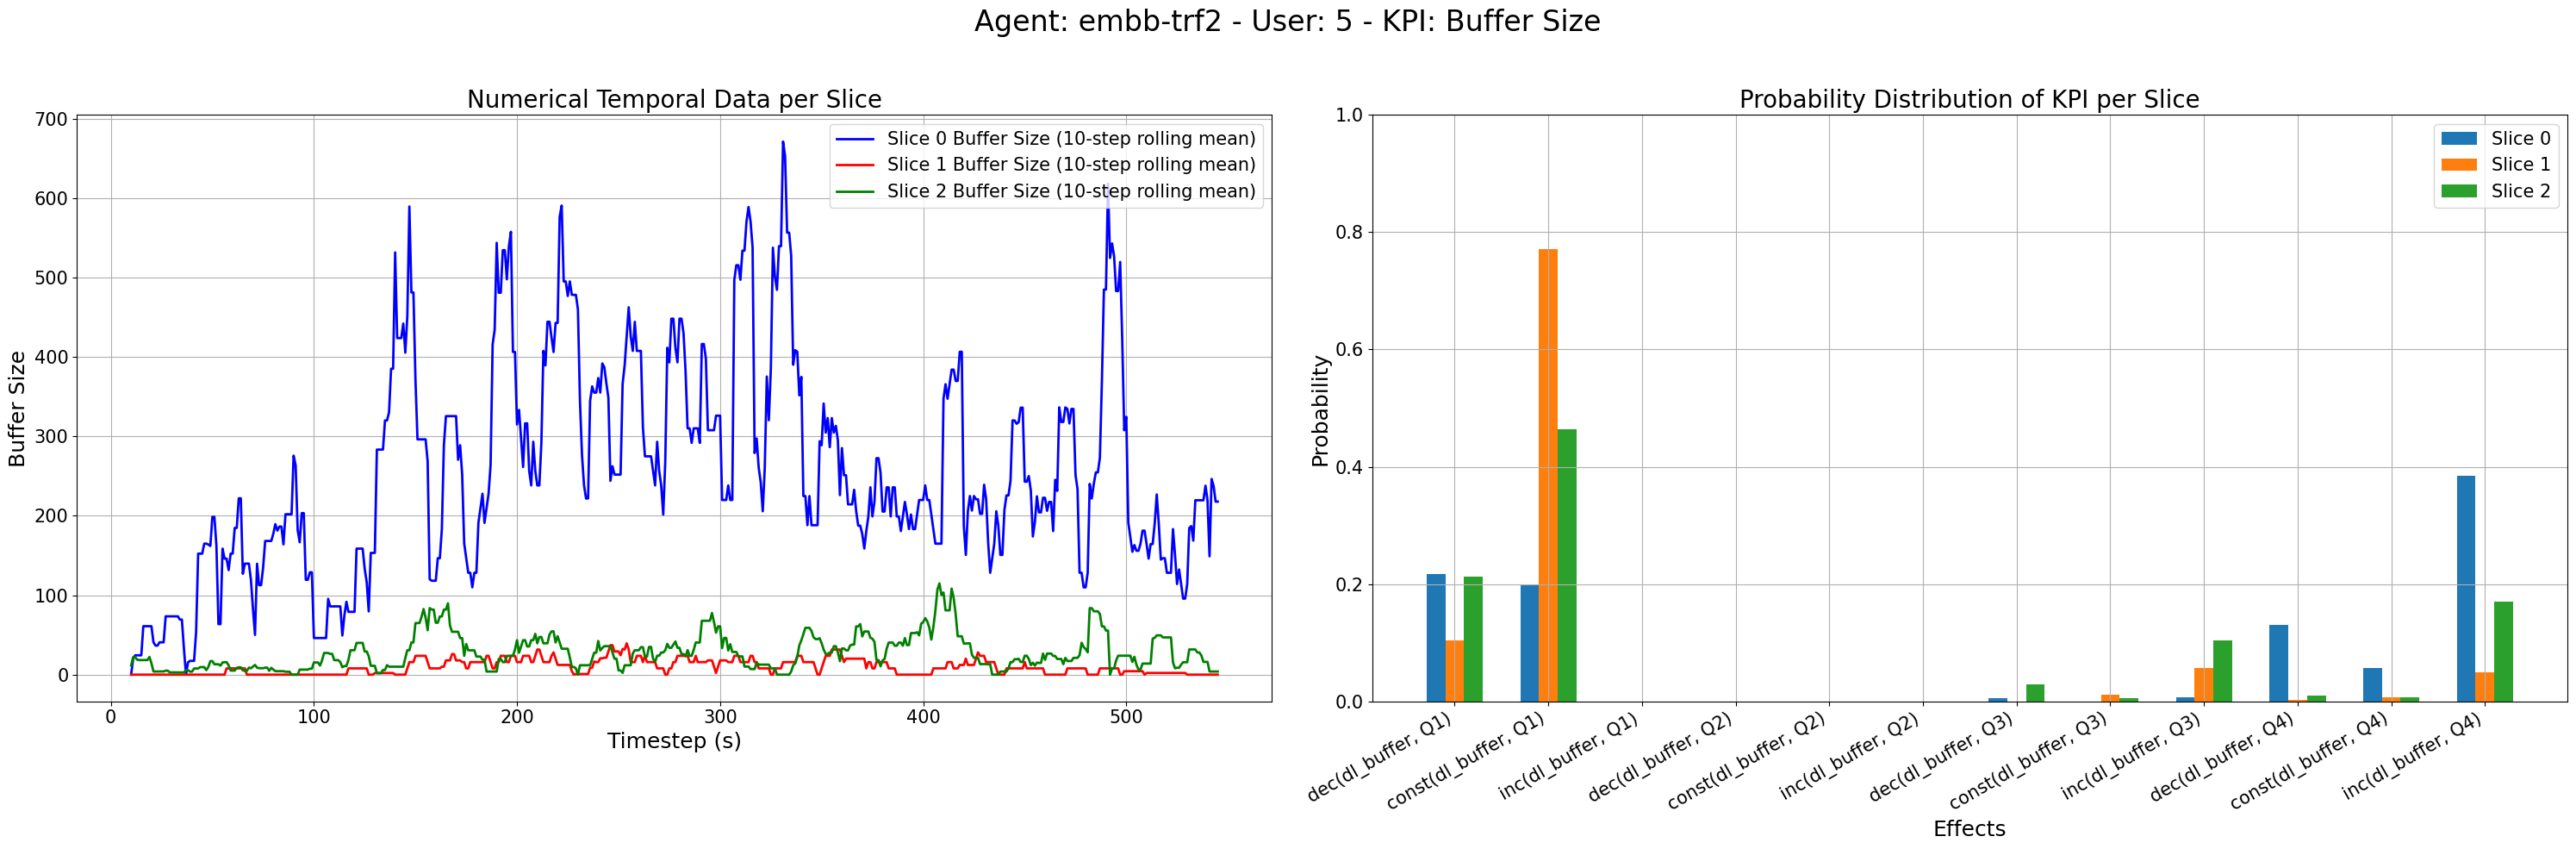

In [28]:
import matplotlib.pyplot as plt
import numpy as np

def create_effects_list(kpis=['dl_buffer'], changes=['dec', 'const', 'inc']):
    return {
        kpi: [f'{change}({kpi}, Q{quartile})' for quartile in range(1, 5) for change in changes] for kpi in kpis
    }

effects_list = create_effects_list()

# Create a 1x2 subplot figure
fig, ax = plt.subplots(1, 2, figsize=(30, 10))

# Main title for the figure
fig.suptitle(f"Agent: {agent} - User: {user} - KPI: Buffer Size", fontsize=24)

# First subplot: Numerical temporal data per slice
colors = ['blue', 'red', 'green']
for slice_id in [0, 1, 2]:
    # Extract the relevant data for each slice
    timestep = kpi_data[kpi_data['slice_id'] == slice_id]['timestep'][10:] - 10
    dl_buffer = kpi_data[kpi_data['slice_id'] == slice_id]['dl_buffer'][10:].rolling(window=10).mean()
    
    # Plot the data
    ax[0].plot(timestep, dl_buffer, label=f'Slice {slice_id} Buffer Size (10-step rolling mean)', color=colors[slice_id], linestyle='-', linewidth=2)

# Add grid, labels, title, and legend for the first subplot
ax[0].grid(True)
ax[0].set_xlabel("Timestep (s)", fontsize=18)
ax[0].set_ylabel("Buffer Size", fontsize=18)
ax[0].set_title("Numerical Temporal Data per Slice", fontsize=20)
ax[0].legend(fontsize=15)
ax[0].tick_params(axis='both', labelsize=15)

# Second subplot: Probability distribution of symbolic effects per slice
bar_width = 0.2
x = np.arange(len(effects_list['dl_buffer']))

for i, slice_id in enumerate([0, 1, 2]):
    effect_counts = symbolic_df[symbolic_df['slice_id'] == slice_id]['dl_buffer'].value_counts(normalize=True).reindex(effects_list['dl_buffer'], fill_value=0).reset_index()
    effect_counts.columns = ['effects', 'probability']
    
    # Plot the data as a bar plot
    ax[1].bar(x + i * bar_width, effect_counts['probability'], bar_width, label=f'Slice {slice_id}')

# Add grid, labels, and title for the second subplot
ax[1].grid(True)
ax[1].set_ylim(bottom=0, top=1)
ax[1].set_xticks(x + bar_width)
ax[1].set_xticklabels(effect_counts['effects'], rotation=30, ha='right', fontsize=12)
ax[1].set_xlabel("Effects", fontsize=18)
ax[1].set_ylabel("Probability", fontsize=18)
ax[1].set_title("Probability Distribution of KPI per Slice", fontsize=20)
ax[1].legend(fontsize=15)
ax[1].tick_params(axis='both', labelsize=15)

# Adjust layout for better fit
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show the plot
plt.show()